In [117]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
import time
from IPython.display import clear_output  # 引入 clear_output
# torch.manual_seed(seed=42)  

os.makedirs("fun_images", exist_ok=True)


In [118]:
layer_num=3
hidden_num=64
sym='no_symetry'

class Mynetwork(nn.Module):
    def __init__(self,input_num=1 , out_num=1,hidden_num=64):
        super().__init__()
        self.MLP=nn.Sequential(
            nn.Linear(input_num, hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,out_num),
        )
        pass
    def forward(self,x):
        return self.MLP(x)+self.MLP(-x)

In [119]:
def potential(x,k):
    poten=1/2*k*x**2
    return poten

In [120]:
def potential_test(x,k):
    mask=(x>0).float()
    mask2=(x<=0).float()
    poten=x**2*mask-30*x*mask2
    return poten

In [121]:
def energy(en_level,k,m,h_bar,device,dtype):
    omega=np.sqrt(k/m)
    en_list=[h_bar*omega*(1/2+i) for i in range(en_level)]
    en_list=torch.tensor(en_list,device=device,dtype=dtype)
    return en_list

In [122]:
#需要适当减小,x_M=sqrt(h_bar/(m*w)*(2n+1)),考虑要>10x_M,700sqrt(h_bar/\omega*m)
h_bar=1
m=1
b_lap:float=-h_bar**2/(2*m)

# 同时对于库伦势函数, 取e=1, 4\pi\epsilon_0=1, E_n=-1/(2n^2)
dtype=torch.float32
device=torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
os.makedirs(f'./model_para_{sym}_{layer_num}_{hidden_num}_{dtype}', exist_ok=True)
La=-10
Lb =10
L=Lb-La  # domain length
N = 3000   # number of interior points # 对时间成本来说几乎是平方量级
h :float= L / (N+1)
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device,requires_grad=True)
grid=grid[1:-1].unsqueeze(-1)
# 角量子数
l=0

k=4
en_num=30
epoch=2500
lr=0.01
l2_reg=0
d2_reg=0

real_en=energy(en_num,k,m,h_bar,device,dtype)

model=Mynetwork().to(device=device,dtype=dtype)
loss_fn=nn.MSELoss()
# Construct the tridiagonal matrix A
diag = -2.0 / h**2 * torch.ones(N,device=device) * b_lap
off_diag = 1.0 / h**2 * torch.ones(N - 1,device=device) * b_lap

V_real_poten=potential(grid,k)
A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_real_poten.flatten())
eigenvalues= torch.linalg.eigvalsh(A)
print('initial eigenvalues check:')
print(eigenvalues[:en_num])


initial eigenvalues check:
tensor([ 1.0003,  2.9988,  5.0004,  6.9991,  9.0011, 10.9993, 13.0005, 14.9992,
        17.0003, 18.9990, 20.9998, 22.9993, 25.0000, 26.9966, 28.9989, 30.9973,
        32.9980, 34.9966, 36.9968, 38.9953, 40.9961, 42.9949, 44.9947, 46.9930,
        48.9938, 50.9925, 52.9926, 54.9914, 56.9916, 58.9902], device='cuda:2',
       grad_fn=<SliceBackward0>)


In [123]:
#pre_train
optimizer_pre=torch.optim.Adam(model.parameters(),lr=0.001)
scheduler_pre = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_pre,patience=20,threshold=1e-4)
V_real_poten=potential(grid,k).detach()
model.train()
for i in range(50000):
    optimizer_pre.zero_grad()
    V_diag=model(grid)
    loss=loss_fn(V_real_poten,V_diag)
    loss.backward()
    optimizer_pre.step()
    if i%20==0:
        print(f'pre_train epoch {i},loss {loss.item()},lr {optimizer_pre.param_groups[0]["lr"]},grad {torch.norm(model.MLP[0].weight.grad)}')
    scheduler_pre.step(loss)
    if optimizer_pre.param_groups[0]["lr"] <= 1.1e-7:break
    pass



pre_train epoch 0,loss 8037.1171875,lr 0.001,grad 122.52733612060547
pre_train epoch 20,loss 6077.16455078125,lr 0.001,grad 349.02490234375
pre_train epoch 40,loss 1944.3099365234375,lr 0.001,grad 711.8723754882812
pre_train epoch 60,loss 754.8318481445312,lr 0.001,grad 518.2570190429688
pre_train epoch 80,loss 435.9332580566406,lr 0.001,grad 190.7085723876953
pre_train epoch 100,loss 257.72882080078125,lr 0.001,grad 53.18207550048828
pre_train epoch 120,loss 171.9376983642578,lr 0.001,grad 47.40472412109375
pre_train epoch 140,loss 136.35630798339844,lr 0.001,grad 27.808706283569336
pre_train epoch 160,loss 117.73270416259766,lr 0.001,grad 21.216461181640625
pre_train epoch 180,loss 102.44654083251953,lr 0.001,grad 24.018827438354492
pre_train epoch 200,loss 90.2016830444336,lr 0.001,grad 20.679006576538086
pre_train epoch 220,loss 80.01850128173828,lr 0.001,grad 19.43442153930664
pre_train epoch 240,loss 70.75192260742188,lr 0.001,grad 17.996047973632812
pre_train epoch 260,loss 62.0

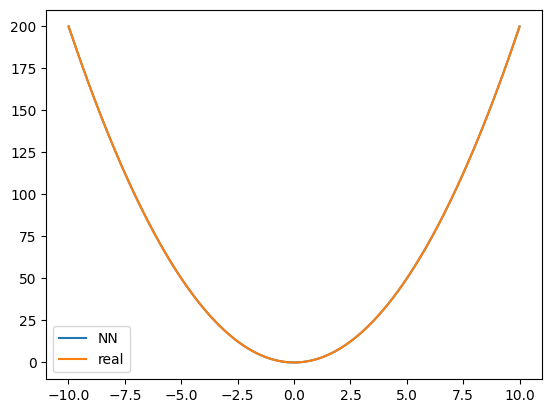

In [125]:
#pre train image
model.eval()

torch.save(model.state_dict(),f'./pre_train.pth')

V_diag=model(grid)
V_real_poten=potential(grid,k)
V_diag=V_diag.cpu().detach().numpy()
V_real_poten=V_real_poten.cpu().detach().numpy()
plt.plot(grid.cpu().detach().numpy(),V_diag,label='NN')
plt.plot(grid.cpu().detach().numpy(),V_real_poten,label='real')
plt.legend()
plt.show()

In [77]:
def regular_loss(model,grid):
    loss=0
    for name, param in model.named_parameters():
        if "weight" in name and param.requires_grad:
            loss+=torch.nn.MSELoss()(param,torch.zeros_like(param))
    return loss

In [78]:
def dd_loss(model,grid):
    potential=model(grid)
    grad_1=torch.autograd.grad(potential,grid,grad_outputs=torch.ones_like(potential),create_graph=True)[0]
    grad_2=torch.autograd.grad(grad_1,grid,grad_outputs=torch.ones_like(potential),create_graph=True)[0]
    
    dd_loss=torch.nn.MSELoss()(grad_2,torch.zeros_like(grad_2))
    
    return dd_loss

In [79]:
optimizer=torch.optim.Adam(model.parameters(),lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=20,threshold=1e-4)
loss_list=[]
init_time=time.time()
for i in range(epoch):
    optimizer.zero_grad()
    V_diag=model(grid)
    A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
    eigenvalues= torch.linalg.eigvalsh(A)
    '''output=NN(input)
    diag=torch.diag(output.flatten())'''
    
    print('\nepoch:',i)
    print(eigenvalues[:en_num+10])
    print(real_en)
    
    output=eigenvalues[:en_num]
    
    re_loss=regular_loss(model,grid)
    val_loss=loss_fn(output,real_en)
    d2_loss=dd_loss(model,grid)
    
    loss=val_loss+re_loss*l2_reg+d2_loss*d2_reg
    loss.backward()
    optimizer.step()
    
    loss_list.append(loss.item())
    
    os.makedirs(f'./fun_images/V_{La}_{Lb}_{N}_{en_num}', exist_ok=True)
    torch.save(V_diag,f'./fun_images/V_{La}_{Lb}_{N}_{en_num}/V_diag_{i}.pth')
    
    if i%10==0:
        # clear_output(wait=True)
        print(f'epoch:{i},loss:{loss},time:{time.time()-init_time},lr:{optimizer.param_groups[0]["lr"]}')
        print('val_loss:',val_loss)
        print('re_loss:',re_loss)
        print('d2_loss:',d2_loss)
    if (i+1)%100==0:torch.save(model.state_dict(),f'./model_para_{sym}_{layer_num}_{hidden_num}_{dtype}/model_para_use_eigvalues_{en_num}_La{La}_Lb{Lb}_N{N}.pth')
    
    scheduler.step(loss)
    if optimizer.param_groups[0]["lr"] <= 1.1e-8:break
print('terminal epoch: ',i+1)
torch.save(model.state_dict(),f'./model_para_{sym}_{layer_num}_{hidden_num}_{dtype}/model_para_use_eigvalues_{en_num}_La{La}_Lb{Lb}_N{N}.pth')



epoch: 0
tensor([ 1.0174,  3.0078,  5.0035,  6.9464,  8.9583, 11.0346, 13.0321, 15.0547,
        17.0726, 19.0668, 21.0641, 23.0530, 25.0199, 26.9845, 28.9560, 30.9351,
        32.9316, 34.9447, 36.9687, 38.9851, 40.9971, 42.9963, 45.0006, 47.0018,
        49.0084, 51.0037, 53.0021, 54.9981, 56.9973, 58.9901, 60.9839, 62.9748,
        64.9694, 66.9629, 68.9593, 70.9588, 72.9633, 74.9701, 76.9817, 78.9908],
       device='cuda:2', grad_fn=<SliceBackward0>)
tensor([ 1.,  3.,  5.,  7.,  9., 11., 13., 15., 17., 19., 21., 23., 25., 27.,
        29., 31., 33., 35., 37., 39., 41., 43., 45., 47., 49., 51., 53., 55.,
        57., 59.], device='cuda:2')
epoch:0,loss:0.0014259801246225834,time:0.0841526985168457,lr:0.01
val_loss: tensor(0.0014, device='cuda:2', grad_fn=<MseLossBackward0>)
re_loss: tensor(0.3593, device='cuda:2', grad_fn=<AddBackward0>)
d2_loss: tensor(31.3733, device='cuda:2', grad_fn=<MseLossBackward0>)

epoch: 1
tensor([ -4.5341,  -1.4562,   1.9475,   5.2752,   8.3827,  11.450

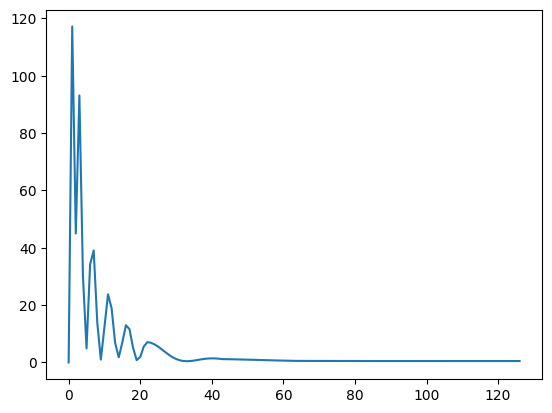

In [80]:
plt.plot(loss_list)
plt.show()

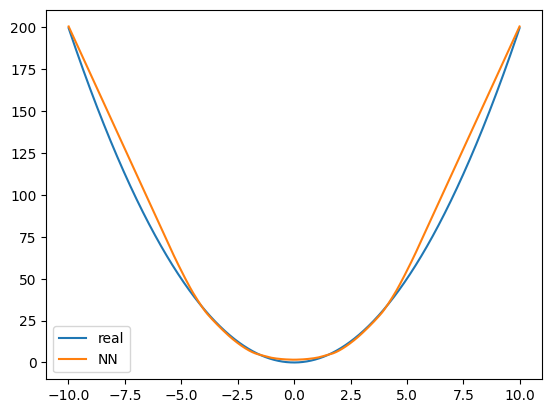

In [81]:
La=-10
Lb =10
L=Lb-La  # domain length
N = 2000   # number of interior points # 对时间成本来说几乎是平方量级
h :float= L / (N+1)
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
V_NN=model(grid)

# V_for_contrast=torch.load(f'./V_NN_30_La-10_Lb10_N2000.pth',map_location=device)

V_NN=V_NN.cpu().detach().numpy()
# V_for_contrast=V_for_contrast.cpu().detach().numpy()

real_poten=potential(grid.cpu().detach().numpy(),k)
plt.plot(grid.cpu().detach().numpy(),real_poten,label='real')
plt.plot(grid.cpu().detach().numpy(),V_NN,label='NN')
# plt.plot(grid.cpu().detach().numpy(),V_for_contrast,label='contrast')
plt.legend()
plt.show()

In [82]:
# os.makedirs(f'./V_NN_value_{sym}_{layer_num}_{hidden_num}_{dtype}', exist_ok=True)
# torch.save(V_NN,f'./V_NN_value_{sym}_{layer_num}_{hidden_num}_{dtype}/V_NN_use_eigvalues_{en_num}_La{La}_Lb{Lb}_N{N}.pth')

In [83]:
error=V_NN-real_poten
mean_error=np.mean(np.abs(error))
max_error=np.max(np.abs(error))
print('mean_error:',mean_error)
print('max_error:',max_error)

mean_error: 5.9444942
max_error: 15.051071
